<h1><center>Deep Learning Course - First Mini Project</center></h1>
<h3><center>Image Classification and Regression</center></h3>
<h4><center>Professor : Vincent Lepetit</center></h4>
<h5><center>Mehdi Boubnan</center></h5>

# Imports and defining functions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from tensorflow import set_random_seed
set_random_seed(1)

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.optimizers import SGD, Adam
from keras import utils as np_utils

Using TensorFlow backend.


In [4]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data',end=".. ")
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data',end=".. ")
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print("Done")
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

        
def visualize_predictions(x, y_true, y_test):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax1.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])

    xy = y_true.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax1.add_patch(tri)
    
    ax1.set_title("True edges")
    
    ax2.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])

    xy = y_test.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax2.add_patch(tri)
    
    ax2.set_title("Predicted edges")
    
    plt.tight_layout()
    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Classification Problem

## Simple Classification

### Generating data

Our training and testing datasets are composed by shapes images (rectangles, disks and triangles). We'll begin by generating some data samples :

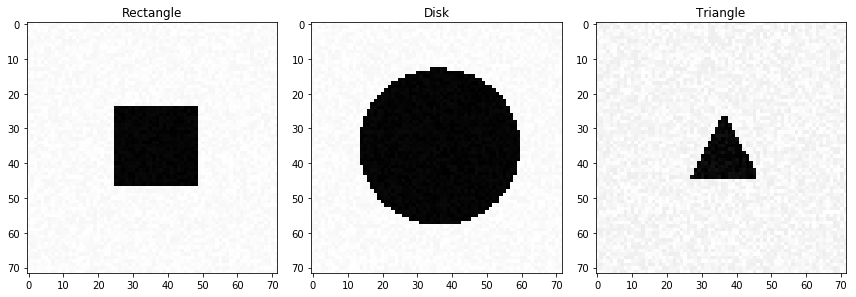

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

im = generate_a_rectangle(10, False)
ax1.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax1.set_title("Rectangle")

im = generate_a_disk(10, False)
ax2.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax2.set_title("Disk")

[im, v] = generate_a_triangle(20, False)
ax3.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax3.set_title("Triangle")

plt.tight_layout()
plt.show()

We'll then generate our training dataset with **300 samples** of shapes images, and see their distribution :

In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data.. Done


We one-hot encore the data labels to fit the model :

In [7]:
Y_train = np_utils.to_categorical(Y_train, 3)

### Building the model

We'll train a simple two layer fully-connected neural network, taking in input vectors in $\mathbb{R}^{5184}$ (our image shapes are 72x72), and outputing a vector in $\mathbb{R}^3$ representing the probabilities of belonging to each of the three classes (rectangle, disk, triangle). To do so, we use one fully connected layer of 3 neurons, followed by a **softmax** activation (logistic regression).

For training the data, we'll firstly use a stochastic gradient descent optimizer, with a 0.001 learning rate, a decay of $10^{-6}$ and a momentum of 0.9, and then use the adam optimizer with default settings.
We'll use 50 epochs and a 32 batch size.

#### Using SGD optimizer

In [8]:
model = Sequential()

output = 3

model.add(Dense(output, input_shape=(5184,)))
model.add(Activation('softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Let's train the model with SGD :

In [9]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)
l, acc = model.evaluate(X_train, Y_train)
print("Last epoch : Loss : {} - Accuracy : {}".format(l, acc))

300/300 [==============================] - 0s 130us/step
Last epoch : Loss : 0.051108248233795166 - Accuracy : 1.0


#### Using Adam optimizer

In [10]:
model = Sequential()

hidden_neurons = 64
output = 3

model.add(Dense(output, input_shape=(5184,)))
model.add(Activation('softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [11]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)
l, acc = model.evaluate(X_train, Y_train)
print("Last epoch : Loss : {} - Accuracy : {}".format(l, acc))

300/300 [==============================] - 0s 149us/step
Last epoch : Loss : 0.016582334153354167 - Accuracy : 1.0


### Plotting weights

We'll plot the first three weights :

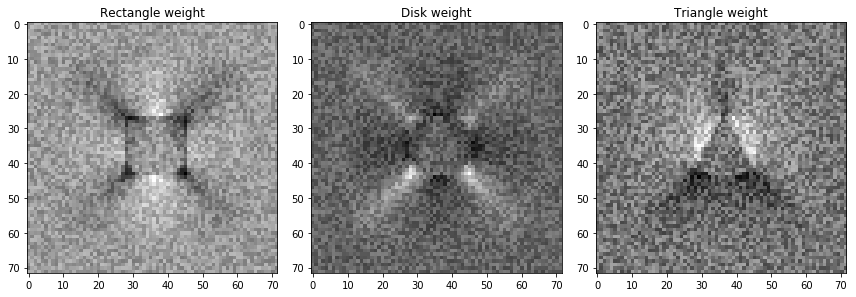

In [12]:
weights = model.get_weights()[0].T

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

ax1.imshow(weights[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax1.set_title("Rectangle weight")

ax2.imshow(weights[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax2.set_title("Disk weight")

ax3.imshow(weights[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax3.set_title("Triangle weight")

plt.tight_layout()
plt.show()

## More Difficult Classification Problem

### Generating Data

Now, we'll generate a new training set where the shapes are allowed to move within the images and change dimensions.

In [13]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data.. Done
Creating data.. Done


Let's see what the new data looks like

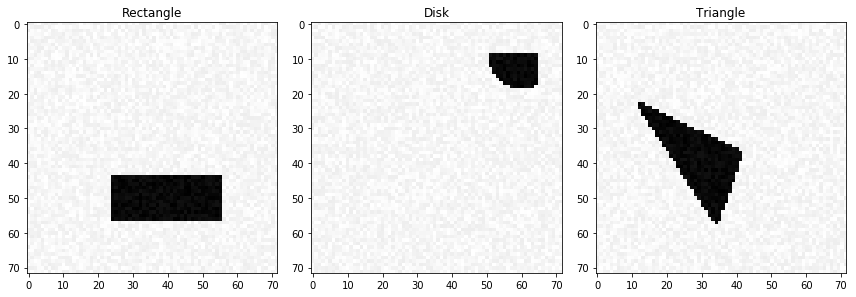

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

im = generate_a_rectangle(20, True)
ax1.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax1.set_title("Rectangle")

im = generate_a_disk(20, True)
ax2.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax2.set_title("Disk")

[im, v] = generate_a_triangle(20, True)
ax3.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax3.set_title("Triangle")

plt.tight_layout()
plt.show()

We one-hot encode the training labels to fit the model, the test labels are already one-hot encoded :

In [15]:
Y_train = np_utils.to_categorical(Y_train, 3)

### Retraining the model

We'll use the **same model as before**, and retrain it on the new dataset. We choose to double the number of **epochs** from **50 to 100**.

In [16]:
model = Sequential()

hidden_neurons = 64
output = 3

model.add(Dense(output, input_shape=(5184,)))
model.add(Activation('softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Let's train our model

In [17]:
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)
l, acc = model.evaluate(X_train, Y_train)
print("Last epoch : Loss : {} - Accuracy : {}".format(l, acc))

300/300 [==============================] - 0s 163us/step
Last epoch : Loss : 0.4893931802113851 - Accuracy : 0.7633333333333333


Let's evaluate our model on the test set :

In [18]:
Loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32)

print("Loss : {}".format(Loss))
print("Accuracy : {}".format(accuracy))

300/300 [==============================] - 0s 77us/step
Loss : 1.1941542307535806
Accuracy : 0.5766666662693024


### Building a convolutional network

We notice that the performance is worse on the new dataset. We'll change the model and use a convolutional network.

The architecture :
  - Convolution with 3 by 3 filters, 8 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Convolution with 3 by 3 filter, 16 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Convolution with 3 by 3 filter, 32 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Flattening
  - Linear layer with 3 outputs units + softmax

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras import utils as np_utils

model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

We reshape the train and test sets to fit the model

In [20]:
X_train = X_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)

Let's train now our model

In [21]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)
l, acc = model.evaluate(X_train, Y_train)
print("Last epoch : Loss : {} - Accuracy : {}".format(l, acc))

300/300 [==============================] - 0s 322us/step
Last epoch : Loss : 0.010246567831685146 - Accuracy : 1.0


Let's evaluate it using the test set

In [22]:
ConvLoss, Conv_accuracy = model.evaluate(X_test, Y_test, batch_size=32)

print("Loss : {}".format(ConvLoss))
print("Accuracy : {}".format(Conv_accuracy))

300/300 [==============================] - 0s 150us/step
Loss : 0.8651260590553284
Accuracy : 0.806666665871938


**Comment**

We clearly see that the convolutional network performs much better than the simple fully connected architecture. Indeed, the CNN extracts features before performing a classification with a fully connected layer, which explains their performance.

# Regression Problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle.

We'll generate 300 triangles for each of the training and test set, knowing the location of the vertices.

In [23]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data.. Done
Creating data.. Done


We can visualize what the data looks like :

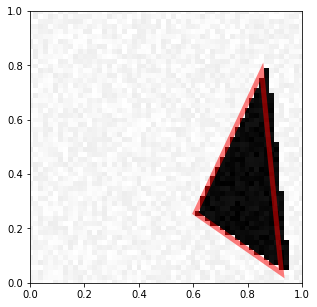

In [24]:
i=np.random.randint(X_train.shape[0])
visualize_prediction(X_train[i], Y_train[i])

We sort the labels by the norm of the vertices for each triangle to give some "meaning" for our labels

In [25]:
def sort_norm(Y):
    a=np.argsort(np.linalg.norm(Y.reshape(-1,3,2),axis=2),axis=1)
    Y_=Y.reshape(-1,3,2)
    for i in range(Y.shape[0]):
        Y_[i]=Y_[i][a[i]]
    return Y_.reshape(Y.shape)

In [26]:
Y_train_sorted = sort_norm(Y_train)
Y_test_sorted = sort_norm(Y_test)

We then center the data and labels to ease the convergence :

In [27]:
X_train = X_train - 0.5
Y_train_sorted = Y_train_sorted - 0.5 

X_test = X_test - 0.5
Y_test_sorted = Y_test_sorted - 0.5

We'll use the following model :

  - Convolution with 5 by 5 filters, 8 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Convolution with 5 by 5 filters, 16 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Convolution with 5 by 5 filters, 32 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Convolution with 5 by 5 filters, 64 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Convolution with 5 by 5 filters, 128 feature maps + ReLU nonlinearity.
  - 2 by 2 max pooling
  - Flattening
  - Fully connected layer with 6 outputs units

In [28]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(5, 5), activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(6, activation='linear'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)

model.compile(loss="mean_absolute_error", optimizer=adam)

We reshape the train and test sets to fit the model

In [29]:
X_train = X_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)

Everything being set, let's train the model :

In [30]:
model.fit(X_train, Y_train_sorted, epochs=100, batch_size=32, validation_data=(X_test,Y_test_sorted), verbose=False)
print("Last epoch : Loss : {}".format(model.evaluate(X_train, Y_train_sorted)))

1000/1000 [==============================] - 0s 138us/step
Last epoch : Loss : 0.01126403073221445


We also evaluate the model on the training set :

In [31]:
print("Test set : Loss : {}".format(model.evaluate(X_test, Y_test_sorted)))

300/300 [==============================] - 0s 161us/step
Test set : Loss : 0.06562974611918132


In [32]:
Y_test_pred=model.predict(X_test)
Y_train_pred=model.predict(X_train)

Let's visualize our predictions on the training set :

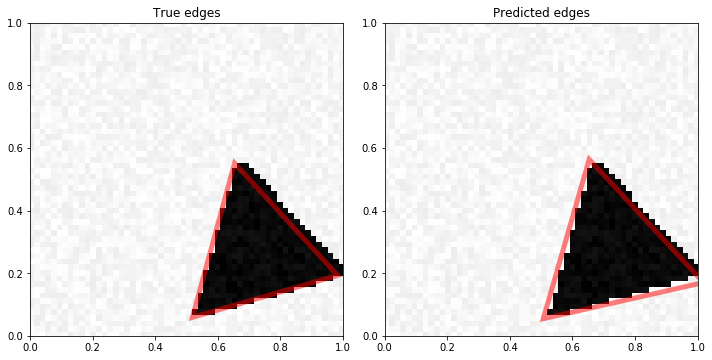

In [33]:
i=np.random.randint(300)

visualize_predictions(X_train[i]+0.5, Y_train_sorted[i]+0.5, Y_train_pred[i]+0.5)

Finally, let's visualize the results on the test set :

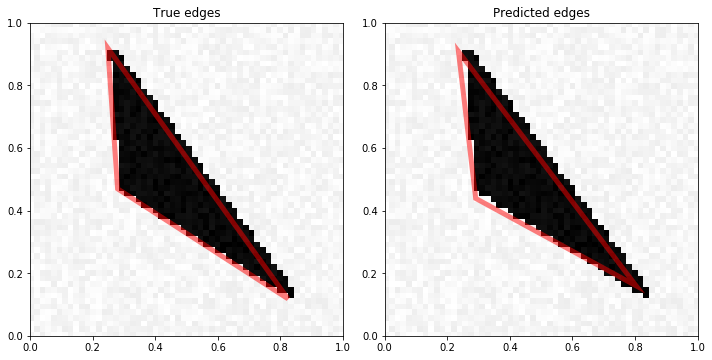

In [34]:
i=np.random.randint(300)

visualize_predictions(X_test[i]+0.5, Y_test_sorted[i]+0.5, Y_test_pred[i]+0.5)

# Image Denoising

We modifiy the code to generate pairs of images where one image has noise with random amplitude from zero to 100, and the second image has the same content but without noise.

In [35]:
def generate_dataset_denoising(nb_samples, noise=50, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X_clear = np.zeros([nb_samples,im_size])
    X_noise = np.zeros([nb_samples,im_size])
    print('Creating data',end=".. ")
    for i in range(nb_samples):
        rng = np.random.randint(9999)
        category = np.random.randint(3)
        if noise>0: rand_noise = np.random.randint(noise)
        else: rand_noise=noise
        if category == 0:
            X_clear[i] = generate_a_rectangle_seed(np.random.RandomState(rng), 0, free_location)
            X_noise[i] = generate_a_rectangle_seed(np.random.RandomState(rng), rand_noise, free_location) 
        elif category == 1: 
            X_clear[i] = generate_a_disk_seed(np.random.RandomState(rng), 0, free_location)
            X_noise[i] = generate_a_disk_seed(np.random.RandomState(rng), rand_noise, free_location)
        else:
            [X_clear[i], V] = generate_a_triangle_seed(np.random.RandomState(rng), 0, free_location)
            [X_noise[i], V] = generate_a_triangle_seed(np.random.RandomState(rng), rand_noise, free_location)
                   
        X_noise[i] = (X_noise[i] + rand_noise) / (255 + 2 * rand_noise)
   
    X_clear = X_clear / 255 
    print("Done")
    return [X_clear, X_noise]

def generate_a_rectangle_seed(rng, noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = rng.uniform(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * rng.uniform()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk_seed(rng, noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = rng.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * rng.uniform()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle_seed(rng, noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = rng.random(3)
        V = rng.random(3)
    else:
        size = (0.3 + 0.7 * rng.uniform())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [36]:
[X_train_clear, X_train_noise] = generate_dataset_denoising(500, 100)
[X_test_clear, X_test_noise] = generate_dataset_denoising(300, 100)

X_train_clear = X_train_clear.reshape(-1, 72, 72, 1)
X_train_noise = X_train_noise.reshape(-1, 72, 72, 1)

X_test_clear = X_test_clear.reshape(-1, 72, 72, 1)
X_test_noise = X_test_noise.reshape(-1, 72, 72, 1)

Creating data.. Done
Creating data.. Done


Let's visualize some data

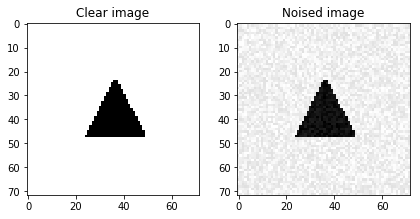

In [37]:
i=np.random.randint(300)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))
ax1.imshow(X_train_clear[i].reshape(72,72), cmap='gray')
ax1.set_title("Clear image")

ax2.imshow(X_train_noise[i].reshape(72,72), cmap='gray')
ax2.set_title("Noised image")

plt.tight_layout()
plt.show()

We define the following autoencoder :

In [38]:
autoencoder = Sequential()

#Encoding
autoencoder.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(72,72,1)))
autoencoder.add(MaxPooling2D(padding='same'))
autoencoder.add(Conv2D(32, (3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(padding='same'))

#Decoding
autoencoder.add(Conv2D(32, (3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(32, (3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D())

autoencoder.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

We train the model

In [39]:
#autoencoder.summary()
autoencoder.fit(X_train_noise, X_train_clear, epochs=50, batch_size=32, verbose=0)
print("Last epoch : Loss : {}".format(autoencoder.evaluate(X_train_noise, X_train_clear)))

500/500 [==============================] - 0s 550us/step
Last epoch : Loss : 0.0019461186081171035


Let's evaluate the model on the test set :

In [40]:
autoencoder.evaluate(X_test_noise, X_test_clear)

300/300 [==============================] - 0s 494us/step


0.001877666978786389

Let's check the results :

In [41]:
X_test_clear_pred = autoencoder.predict(X_test_noise)

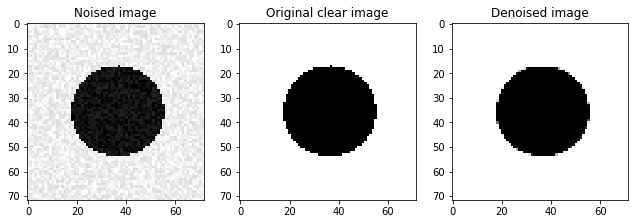

In [42]:
i=np.random.randint(300)

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3))
ax1.imshow(X_test_noise[i].reshape(72,72), cmap="gray")
ax1.set_title("Noised image")

ax2.imshow(X_test_clear[i].reshape(72,72), cmap="gray")
ax2.set_title("Original clear image")

ax3.imshow(X_test_clear_pred[i].reshape(72,72), cmap="gray")
ax3.set_title("Denoised image")

plt.tight_layout()
plt.show()